In [867]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline


### 10-armed testbed

In [3]:
import random
random.seed(1)

max_num_tasks = 2000
num_arms = 10
num_plays = 1000


In [4]:
# Created the testbed
random.seed(1)
Q_star = np.zeros((max_num_tasks, num_arms))
for task in range(max_num_tasks):
#     for arm in range(num_arms):
    Q_star[task, :] = np.random.normal(0, 1, 10)


In [19]:
# epsilon is the probability of choosing a random arm
epsilon = [0, 0.01, 0.1]

all_rewards = np.zeros((len(epsilon), max_num_tasks, num_plays))
picked_max_action = np.zeros((len(epsilon), max_num_tasks, num_plays))

for eps_idx, eps in enumerate(epsilon):
    print eps
    qT = np.zeros(Q_star.shape)
    qN = np.zeros( (max_num_tasks, num_arms) )
    qS = qT.copy()
    for b in range(max_num_tasks):
        best_arm = np.argmax(Q_star[b, :])
        for p in range(num_plays):
            if np.random.uniform(0, 1) <= eps:
                # pick a random arm
                arm = np.random.randint(0, num_arms)
            else:
                # pick greedy arm
                arm = np.argmax(qT[b, :])
            
            # determine if arm selected is the best possible
            if arm == best_arm:
                picked_max_action[eps_idx, b, p] = 1
                
            # Insert some noise in the reward
            reward = Q_star[b, arm] + np.random.normal(0, 1)
            all_rewards[eps_idx, b, p] = reward
            qN[b, arm] = qN[b, arm] + 1
            qS[b, arm] = qS[b, arm] + reward
            qT[b, arm] = qS[b, arm] / qN[b, arm]
#         break
            
        


0
0.01
0.1


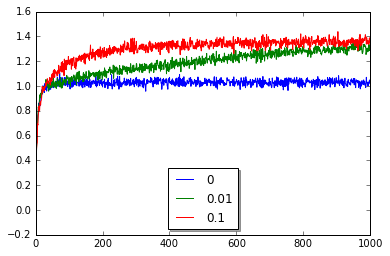

In [20]:
# Avg reward vs plays
fig, ax = plt.subplots()
for eps_idx, eps in enumerate(epsilon):
    ax.plot(range(num_plays), np.mean(all_rewards[eps_idx,:,:], axis=0), label=eps)
    
legend = ax.legend(loc='lower center', shadow=True)
plt.show()

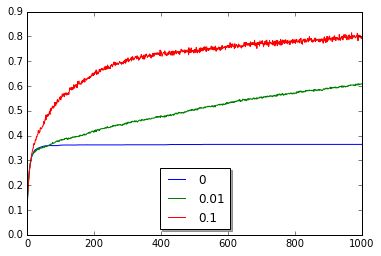

In [21]:

fig, ax = plt.subplots()
for eps_idx, eps in enumerate(epsilon):
    ax.plot(np.mean(picked_max_action[eps_idx, :, :], axis=0), label=eps)
    
legend = ax.legend(loc='lower center', shadow=True)
plt.show()

### Softmax selection

In [395]:
# If tau is too small, we have underflow error...
tau = [.05, .1, .15]

all_rewards = np.zeros((len(tau), max_num_tasks, num_plays))
picked_max_action = np.zeros((len(tau), max_num_tasks, num_plays))

for tau_idx, t in enumerate(tau):
    qT = np.zeros(Q_star.shape)
    qN = np.zeros( (max_num_tasks, num_arms) )
    qS = qT.copy()
    for b in range(max_num_tasks):
        best_arm = np.argmax(Q_star[b, :])
        
        for p in range(num_plays):
            softmax = np.exp(qT[b, :] / t) / np.sum(np.exp(qT[b, :] / t))
            # choose arm with probabilitiy in softmax
            cum = np.cumsum(softmax)
            selection = np.random.uniform(0, 1)
            arm = np.sum(selection > cum)

            # determine if arm selected is the best possible
            if arm == best_arm:
                picked_max_action[tau_idx, b, p] = 1
                
            # Insert some noise in the reward
            reward = Q_star[b, arm] + np.random.normal(0, 1)
            all_rewards[tau_idx, b, p] = reward
            qN[b, arm] = qN[b, arm] + 1
            qS[b, arm] = qS[b, arm] + reward
            qT[b, arm] = qS[b, arm] / qN[b, arm]
                    
        


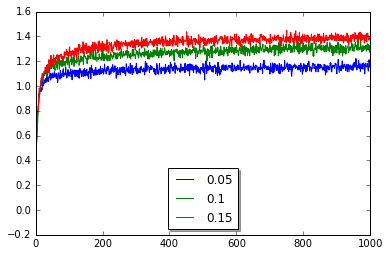

In [396]:
# Avg reward vs plays
fig, ax = plt.subplots()
for eps_idx, eps in enumerate(tau):
    ax.plot(range(num_plays), np.mean(all_rewards[eps_idx,:,:], axis=0), label=eps)
    
legend = ax.legend(loc='lower center', shadow=True)
plt.show()

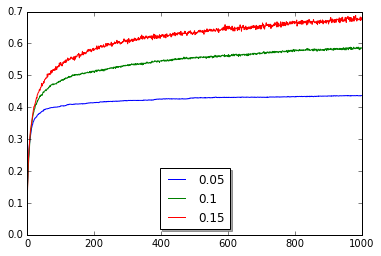

In [397]:
# Percent picked max action vs plays
fig, ax = plt.subplots()
for eps_idx, eps in enumerate(tau):
    ax.plot(np.mean(picked_max_action[eps_idx, :, :], axis=0), label=eps)
    
legend = ax.legend(loc='lower center', shadow=True)
plt.show()

### Incremental Implemenation

$\alpha_k(a) = \frac{1}{k_a}$

https://webdocs.cs.ualberta.ca/~sutton/book/ebook/node19.html

In [398]:
# epsilon is the probability of choosing a random arm
alpha = 1
epsilon = [0.1]

all_rewards = np.zeros((len(epsilon), max_num_tasks, num_plays))
picked_max_action = np.zeros((len(epsilon), max_num_tasks, num_plays))

for eps_idx, eps in enumerate(epsilon):
    print eps
    qT = np.zeros(Q_star.shape)
    qTold = np.zeros(Q_star.shape)
    qS = qTold.copy()
    qN = np.zeros( (max_num_tasks, num_arms) )
    for b in range(max_num_tasks):
        best_arm = np.argmax(Q_star[b, :])
        for p in range(num_plays):
            if np.random.uniform(0, 1) <= eps:
                # pick a random arm
                arm = np.random.randint(0, num_arms)
            else:
                # pick greedy arm
                arm = np.argmax(qT[b, :])
            
            # determine if arm selected is the best possible
            if arm == best_arm:
                picked_max_action[eps_idx, b, p] = 1
                
            # Insert some noise in the reward
            reward = Q_star[b, arm] + np.random.normal(0, 1)
            all_rewards[eps_idx, b, p] = reward
            qN[b, arm] = qN[b, arm] + 1
            
            # Increment the Q without cached sum of rewards
            qT[b, arm] = qT[b, arm] + (alpha / qN[b, arm]) * (reward - qT[b, arm])
            
            # Find new Q using cached sum of rewards
            qS[b, arm] = qS[b, arm] + reward
            qTold[b, arm] = qS[b, arm] / qN[b, arm]
            

        


0.1


In [402]:
np.allclose(qTold, qT)

True

In [408]:
np.alltrue((qTold - qT) < 1e-13)

True

### Nonstationary Problems

Decay the updates so that recent rewards are weighed more heavily

https://webdocs.cs.ualberta.ca/~sutton/book/ebook/node20.html

Design and conduct an experiment to demonstrate the difficulties that sample-average methods have for nonstationary problems. Use a modified version of the 10-armed testbed in which all the $Q*(a)$ start out equal and then take independent random walks. Prepare plots like Figure  2.1 for an action-value method using sample averages, incrementally computed by $\alpha = \frac{1}{k}$, and another action-value method using a a constant step-size parameter, $\alpha=.1$. Use $\epsilon = 0.1$  and, if necessary, runs longer than 1000 plays.

In [409]:
random.seed(1)
Q_star = np.zeros((max_num_tasks, num_arms))
for task in range(max_num_tasks):
#     for arm in range(num_arms):
    Q_star[task, :] = np.random.normal(0, 1, 10)


In [429]:
# epsilon is the probability of choosing a random arm
alpha = 0.1
non_stationary_sigma = [0.1, .5, 1]
esp = 0.1

num_plays = 2000
all_rewards = np.zeros((len(non_stationary_sigma), max_num_tasks, num_plays))
picked_max_action = np.zeros((len(non_stationary_sigma), max_num_tasks, num_plays))

all_rewards_exp_avg = np.zeros((len(non_stationary_sigma), max_num_tasks, num_plays))
picked_max_action_exp_avg = np.zeros((len(non_stationary_sigma), max_num_tasks, num_plays))

for eps_idx, ns_sig in enumerate(non_stationary_sigma):
    qT = np.zeros(Q_star.shape)
    qT_exp_avg = np.zeros(Q_star.shape)
    qN = np.zeros( (max_num_tasks, num_arms) )
    qN_exp_avg = np.zeros( (max_num_tasks, num_arms) )
    for b in range(max_num_tasks):
        for p in range(num_plays):
            
            # Include non-stationarity in Q_star,
            # each arm takes a random walk, with N(0, ns_sig)
            Q_star[b, :] += np.random.normal(0, ns_sig, 10)
            best_arm = np.argmax(Q_star[b, :])
            
            if np.random.uniform(0, 1) <= eps:
                # pick a random arm
                arm = np.random.randint(0, num_arms)
                arm_exp_avg = np.random.randint(0, num_arms)
            else:
                # pick greedy arm
                arm = np.argmax(qT[b, :])
                arm_exp_avg = np.argmax(qT_exp_avg[b, :])
            
            # determine if arm selected is the best possible
            if arm == best_arm:
                picked_max_action[eps_idx, b, p] = 1
                
            if arm_exp_avg == best_arm:
                picked_max_action_exp_avg[eps_idx, b, p] = 1
                
            # Insert some noise in the reward
            noise = np.random.normal(0, 1)
            reward = Q_star[b, arm] + noise
            reward_exp_avg = Q_star[b, arm_exp_avg] + noise
            
            # Update step
            all_rewards[eps_idx, b, p] = reward
            qN[b, arm] = qN[b, arm] + 1
            qT[b, arm] = qT[b, arm] + (1 / qN[b, arm]) * (reward - qT[b, arm])
            
            all_rewards_exp_avg[eps_idx, b, p] = reward_exp_avg
            qN_exp_avg[b, arm_exp_avg] = qN_exp_avg[b, arm_exp_avg] + 1
            qT_exp_avg[b, arm_exp_avg] = qT_exp_avg[b, arm_exp_avg] + (alpha) * (reward_exp_avg - qT_exp_avg[b, arm_exp_avg])


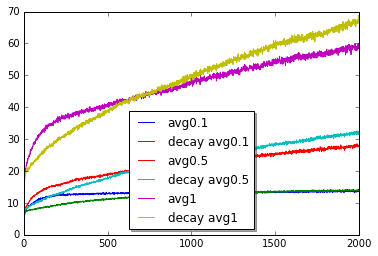

In [431]:
# Avg reward vs plays
fig, ax = plt.subplots()

for idx, ns_sig in enumerate(non_stationary_sigma):
    ax.plot(range(num_plays), np.mean(all_rewards[idx,:,:], axis=0), label='avg' + str(ns_sig))
    ax.plot(range(num_plays), np.mean(all_rewards_exp_avg[idx,:,:], axis=0), label='decay avg' + str(ns_sig))
    
legend = ax.legend(loc='lower center', shadow=True)
plt.show()

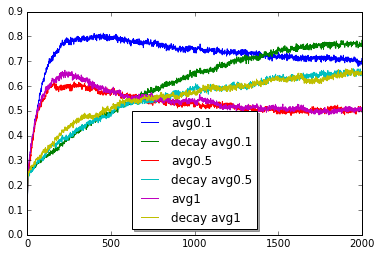

In [432]:
# Percent picked max action vs plays
fig, ax = plt.subplots()

for idx, ns_sig in enumerate(non_stationary_sigma):
    ax.plot(np.mean(picked_max_action[idx, :, :], axis=0), label='avg' + str(ns_sig))
    ax.plot(np.mean(picked_max_action_exp_avg[idx, :, :], axis=0), label='decay avg' + str(ns_sig))
    
legend = ax.legend(loc='lower center', shadow=True)
plt.show()

### Optimistic Initial Values

**Any method that focuses on the initial state in any special way is unlikely to help with the general nonstationary case.**

https://webdocs.cs.ualberta.ca/~sutton/book/ebook/node21.html

Try the non-stationary decayed average updates with an optimistic start state, compared to non-optimistic start-state.

In [14]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(42)

max_num_tasks = 2000
num_arms = 10
num_plays = 1500

Q_star = np.zeros((max_num_tasks, num_arms))
for task in range(max_num_tasks):
    Q_star[task, :] = np.random.normal(0, 1, 10)


In [15]:
# epsilon is the probability of choosing a random arm
eps = 0.1
# alpha is the step-size of the update to Q
alpha = 0.1
# different initial values for Q_0
optimism = [-1, .5, 1, 5, 10]

# REALIST
all_rewards = np.zeros((len(optimism), max_num_tasks, num_plays))
picked_max_action = np.zeros((len(optimism), max_num_tasks, num_plays))

# OPTIMIST
all_rewards_opt = np.zeros((len(optimism), max_num_tasks, num_plays))
picked_max_action_opt = np.zeros((len(optimism), max_num_tasks, num_plays))

for eps_idx, opt in enumerate(optimism):
    
    qT = np.zeros(Q_star.shape)
    qN = np.zeros( (max_num_tasks, num_arms) )
    qT_optimistic = np.zeros(Q_star.shape) + opt
    qN_optimistic = qN.copy()
    
    for b in range(max_num_tasks):
        best_arm = np.argmax(Q_star[b, :])
        #Q_star_nonstationary = Q_star.copy()
        for p in range(num_plays):
            
            # Include non-stationarity in Q_star,
            # each arm takes a random walk, with N(0, ns_sig)
            #Q_star_nonstationary[b, :] += np.random.normal(0, .1, 10)
            #best_arm = np.argmax(Q_star_nonstationary[b, :])
            
            if np.random.uniform(0, 1) <= eps:
                # pick a random arm
                # both the optimist and realist pick the same arm 
                #  in this case
                arm = np.random.randint(0, num_arms)
                arm_opt = arm
            else:
                # pick greedy arm
                # the optimist and realist have different expecations
                arm = np.argmax(qT[b, :])
                arm_opt = np.argmax(qT_optimistic[b, :])
            
            # determine if arm selected is the best possible
            if arm == best_arm:
                picked_max_action[eps_idx, b, p] = 1
                
            if arm_opt == best_arm:
                picked_max_action_opt[eps_idx, b, p] = 1
                
            # Insert some noise in the reward
            noise = np.random.normal(0, 1)
            
            #reward = Q_star_nonstationary[b, arm] + noise
            reward = Q_star[b, arm] + noise
            all_rewards[eps_idx, b, p] = reward
            qN[b, arm] += 1            
            # qT[b, arm] = qT[b, arm] + (1 / qN[b, arm]) * (reward - qT[b, arm])
            qT[b, arm] = qT[b, arm] + (alpha) * (reward - qT[b, arm])
            
            #reward_opt = Q_star_nonstationary[b, arm_opt] + noise
            reward_opt = Q_star[b, arm_opt] + noise
            all_rewards_opt[eps_idx, b, p] = reward_opt
            qN_optimistic[b, arm_opt] += 1
            # qT_optimistic[b, arm_opt] = qT_optimistic[b, arm_opt] + (1 / qN_optimistic[b, arm_opt]) * (reward_opt - qT_optimistic[b, arm_opt])
            qT_optimistic[b, arm_opt] = qT_optimistic[b, arm_opt] + (alpha) * (reward_opt - qT_optimistic[b, arm_opt])


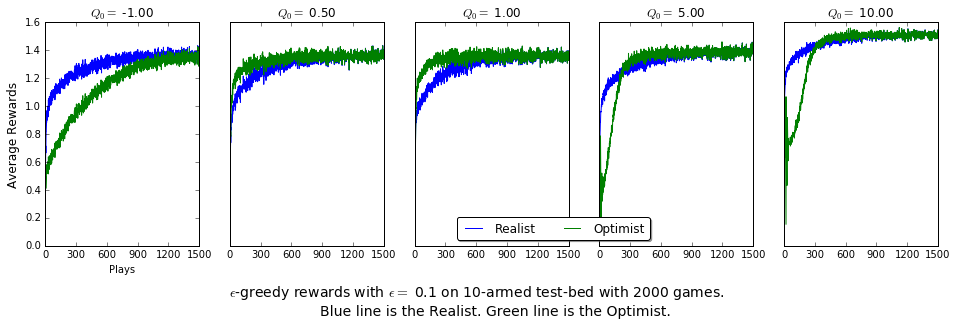

In [39]:
# Avg reward vs plays
fig, ax = plt.subplots(1, 5, figsize=(16, 4))

for idx, opt in enumerate(optimism):
    ax[idx].plot(range(num_plays), np.mean(all_rewards[idx,:,:], axis=0), label='Realist')
    ax[idx].plot(range(num_plays), np.mean(all_rewards_opt[idx,:,:], axis=0), label='Optimist')
    ax[idx].set_title('$Q_0=$ %.2f' % opt)
    ax[idx].set_xticks(xrange(0, num_plays+1, 300))
    ax[idx].set_xlim((0, num_plays))
    if idx == 0:
        ax[idx].set_ylabel('Average Rewards', fontsize=12)
        ax[idx].set_xlabel('Plays')
    if idx != 0:
        ax[idx].get_yaxis().set_ticks([])
    if idx == len(optimism) - 1:
        plt.legend(loc='lower center', shadow=True, bbox_to_anchor=(-1.5, 0),
          ncol=2, fancybox=True)

fig.suptitle('''$\epsilon$-greedy rewards with $\epsilon=$ %.1f on 10-armed test-bed with 2000 games.
        Blue line is the Realist. Green line is the Optimist.''' % eps, 
             fontsize=14, x=.5, y=0)
plt.savefig('avg_reward')

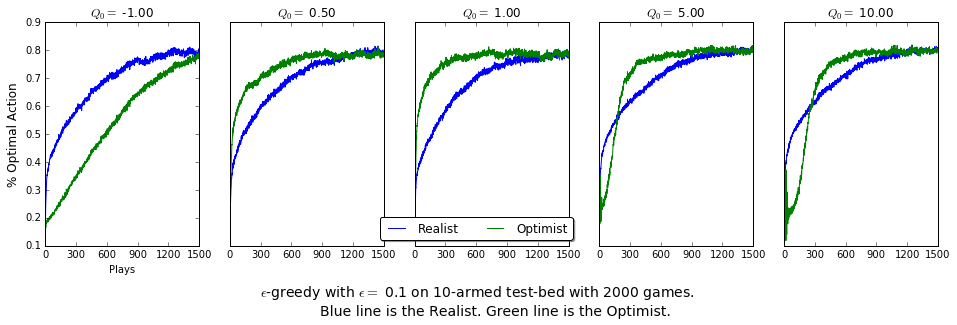

In [40]:
# Percent picked max action vs plays
fig, ax = plt.subplots(1, 5, figsize=(16, 4))

for idx, opt in enumerate(optimism):
    ax[idx].plot(range(num_plays), np.mean(picked_max_action[idx,:,:], axis=0), label='Realist')
    ax[idx].plot(range(num_plays), np.mean(picked_max_action_opt[idx,:,:], axis=0), label='Optimist')
    ax[idx].set_title('$Q_0=$ %.2f' % opt)
    ax[idx].set_xticks(xrange(0, num_plays+1, 300))
    ax[idx].set_xlim((0, num_plays))
    if idx == 0:
        ax[idx].set_ylabel('% Optimal Action', fontsize=12)
        ax[idx].set_xlabel('Plays')
    if idx != 0:
        ax[idx].get_yaxis().set_ticks([])
    if idx == len(optimism) - 1:
        plt.legend(loc='lower center', shadow=True, bbox_to_anchor=(-2, 0),
          ncol=2, fancybox=True)

fig.suptitle('''$\epsilon$-greedy with $\epsilon=$ %.1f on 10-armed test-bed with 2000 games.
        Blue line is the Realist. Green line is the Optimist.''' % eps, 
             fontsize=14, x=.5, y=0)
plt.savefig('pct_optimal_action', )

Make a blog post on the value iteration with optimistic start with non-stationary 10-armed test bed. If you get too optimistic, you wind up getting too disappointed and flip-flop in the beginning. If you have no prior optimism and are realistic, you wind up getting less optimal actions in the beginning. Of course, both methods converge in the long-run, which is a criticism of Optimistic Initial Values in general. Your long term strategy will determine convergence. But I still think there is something profound in 10 buckets of random gaussians...or not. 

### Reinforcement Comparison

actions followed by large rewards should be made more likely to recur, whereas actions followed by small rewards should be made less likely to recur.
Reinforcement comparison methods typically do not maintain estimates of action values, but only of an overall reward level.

In [959]:
# epsilon is the probability of choosing a random arm
num_plays = 1000

alpha = 0.1
beta = [0.05, .1, .15]
eps = 0.1

all_rewards = np.zeros((len(beta), max_num_tasks, num_plays))
picked_max_action = np.zeros((len(beta), max_num_tasks, num_plays))

all_rewards_comp = np.zeros((len(beta), max_num_tasks, num_plays))
picked_max_action_comp = np.zeros((len(beta), max_num_tasks, num_plays))

# From exercise 2.11
all_rewards_comp_211 = np.zeros((len(beta), max_num_tasks, num_plays))
picked_max_action_comp_211 = np.zeros((len(beta), max_num_tasks, num_plays))


for eps_idx, bt in enumerate(beta):
    # eps-greedy
    qT = np.zeros(Q_star.shape)
    qN = np.zeros( (max_num_tasks, num_arms) )
    
    # projection pursuit parameters
    pref = np.zeros(Q_star.shape)
    ref_reward = 0
    pref_211 = np.zeros(Q_star.shape)
    ref_reward_211 = 0
    
    for b in range(max_num_tasks):
        best_arm = np.argmax(Q_star[b, :])
        for p in range(num_plays):
            if np.random.uniform(0, 1) <= eps:
                # pick a random arm
                arm = np.random.randint(0, num_arms)
            else:
                # pick greedy arm
                arm = np.argmax(qT[b, :])

            # determine if arm selected is the best possible
            if arm == best_arm:
                picked_max_action[eps_idx, b, p] = 1
                
            # Insert some noise in the reward
            reward = Q_star[b, arm] + np.random.normal(0, 1)
            all_rewards[eps_idx, b, p] = reward
            qN[b, arm] = qN[b, arm] + 1
            qT[b, arm] = qT[b, arm] + (1 / qN[b, arm]) * (reward - qT[b, arm])
            
            # Reinforcement Comparison
            pr = np.exp(pref[b, :])
            pr = pr / sum(pr)
            cum = np.cumsum(pr)
            selection = np.random.uniform(0, 1)
            arm = np.sum(selection > cum)
            if arm == best_arm:
                picked_max_action_comp[eps_idx, b, p] = 1
            # update preferences
            reward = Q_star[b, arm] + np.random.normal(0, 1)
            all_rewards_comp[eps_idx, b, p] = reward
            pref[b, arm] += bt * (reward - ref_reward)
            ref_reward += alpha * (reward - ref_reward)
            
            # Exercise 2.11
            pr = np.exp(pref_211[b, :])
            pr = pr / sum(pr)
            cum = np.cumsum(pr)
            selection = np.random.uniform(0, 1)
            arm = np.sum(selection > cum)
            if arm == best_arm:
                picked_max_action_comp_211[eps_idx, b, p] = 1
            # update preferences
            reward = Q_star[b, arm] + np.random.normal(0, 1)
            all_rewards_comp_211[eps_idx, b, p] = reward
            pref_211[b, arm] += bt * (reward - ref_reward) * (1 - pr[arm])
            ref_reward_211 += alpha * (reward - ref_reward)
    

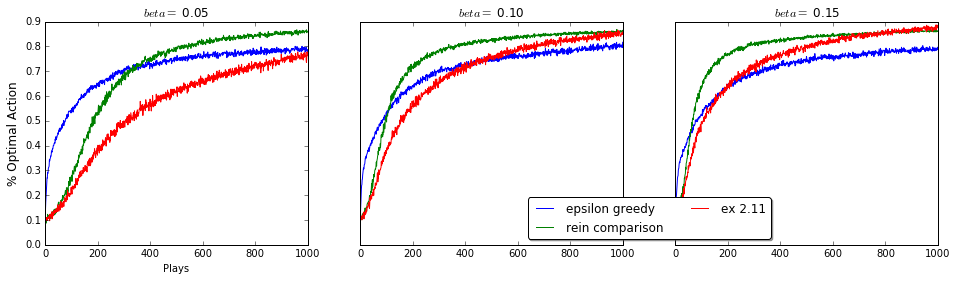

In [964]:
# Avg reward vs plays
fig, ax = plt.subplots(1, len(beta), figsize=(16, 4))

for idx, bt in enumerate(beta):
    ax[idx].plot(range(num_plays), np.mean(picked_max_action[idx,:,:], axis=0), label='epsilon greedy')
    ax[idx].plot(range(num_plays), np.mean(picked_max_action_comp[idx,:,:], axis=0), label='rein comparison')
    ax[idx].plot(range(num_plays), np.mean(picked_max_action_comp_211[idx,:,:], axis=0), label='ex 2.11')
    ax[idx].set_title('$beta=$ %.2f' % bt)
    if idx == 0:
        ax[idx].set_ylabel('% Optimal Action', fontsize=12)
        ax[idx].set_xlabel('Plays')
    if idx != 0:
        ax[idx].get_yaxis().set_ticks([])
    if idx == len(beta) - 1:
        plt.legend(loc='lower center', shadow=True, bbox_to_anchor=(-.1, 0),
          ncol=2, fancybox=True)

plt.show()

### Pursuit Methods

In [1494]:
# epsilon is the probability of choosing a random arm
num_plays = 1000

alpha = 0.1
beta = [0.01]
eps = 0.1

all_rewards = np.zeros((len(beta), max_num_tasks, num_plays))
picked_max_action = np.zeros((len(beta), max_num_tasks, num_plays))

all_rewards_comp = np.zeros((len(beta), max_num_tasks, num_plays))
picked_max_action_comp = np.zeros((len(beta), max_num_tasks, num_plays))

all_rewards_pursuit = np.zeros((len(beta), max_num_tasks, num_plays))
picked_max_action_pursuit = np.zeros((len(beta), max_num_tasks, num_plays))


for eps_idx, bt in enumerate(beta):
    # eps-greedy
    qT = np.zeros(Q_star.shape)
    qT_proj = np.zeros(Q_star.shape)
    qN = np.zeros( (max_num_tasks, num_arms) )
    qN_proj = np.zeros( (max_num_tasks, num_arms) )
    
    # projection pursuit parameters
    pref = np.zeros(Q_star.shape)
    ref_reward = 0
    pref_proj = np.ones(Q_star.shape) * 1. / num_arms
    
    for b in range(max_num_tasks):
        best_arm = np.argmax(Q_star[b, :])
        for p in range(num_plays):
            if np.random.uniform(0, 1) <= eps:
                # pick a random arm
                arm = np.random.randint(0, num_arms)
            else:
                # pick greedy arm
                # arm = np.argmax(qT[b, :])
                arm = np.random.choice(np.where(qT[b, :] == np.max(qT[b, :]))[0])

            # determine if arm selected is the best possible
            if arm == best_arm:
                picked_max_action[eps_idx, b, p] = 1
                
            # Insert some noise in the reward
            reward = Q_star[b, arm] + np.random.normal(0, 1)
            all_rewards[eps_idx, b, p] = reward
            qN[b, arm] = qN[b, arm] + 1
            qT[b, arm] = qT[b, arm] + (1 / qN[b, arm]) * (reward - qT[b, arm])

            # Pursuit
            cum = np.cumsum(pref_proj[b, :])
            selection = np.random.uniform(0, 1)
            arm = np.sum(selection > cum)
            if arm == best_arm:
                picked_max_action_pursuit[eps_idx, b, p] = 1

            reward = Q_star[b, arm] + np.random.normal(0, 1)
            all_rewards_pursuit[eps_idx, b, p] = reward
            # sample average method
            qN_proj[b, arm] = qN_proj[b, arm] + 1
            qT_proj[b, arm] = qT_proj[b, arm] + (1 / qN_proj[b, arm]) * (reward - qT_proj[b, arm])
            
            # update the probabilities
            a_star = np.random.choice(np.where(qT_proj[b, :] == np.max(qT_proj[b, :]))[0])
            pref_proj[b, a_star] = pref_proj[b, a_star] + bt * (1 - pref_proj[b, a_star])
            other_arms = list(set(range(num_arms)) - set([int(a_star)]))
            for a in other_arms:
                pref_proj[b, a] += bt * (0 - pref_proj[b, a]) 

            # Reinforcement Comparison
            pr = np.exp(pref[b, :])
            pr = pr / sum(pr)
            cum = np.cumsum(pr)
            selection = np.random.uniform(0, 1)
            arm = np.sum(selection > cum)
            if arm == best_arm:
                picked_max_action_comp[eps_idx, b, p] = 1
            # update preferences
            reward = Q_star[b, arm] + np.random.normal(0, 1)
            all_rewards_comp[eps_idx, b, p] = reward
            pref[b, arm] += .15 * (reward - ref_reward)
            ref_reward += alpha * (reward - ref_reward)
    

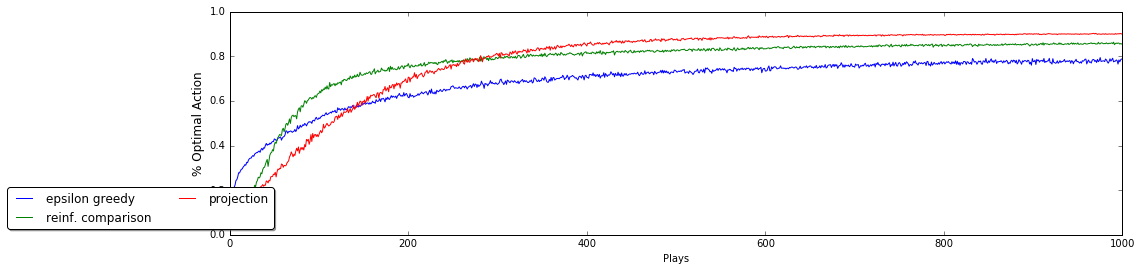

In [1495]:
# Avg reward vs plays
fig, ax = plt.subplots(1, len(beta), figsize=(16, 4))
ax = [ax]
for idx, bt in enumerate(beta):
    ax[idx].plot(range(num_plays), np.mean(picked_max_action[idx,:,:], axis=0), label='epsilon greedy')
    ax[idx].plot(range(num_plays), np.mean(picked_max_action_comp[idx,:,:], axis=0), label='reinf. comparison')
    ax[idx].plot(range(num_plays), np.mean(picked_max_action_pursuit[idx,:,:], axis=0), label='projection')
    if idx == 0:
        ax[idx].set_ylabel('% Optimal Action', fontsize=12)
        ax[idx].set_xlabel('Plays')
#     if idx != 0:
#         ax[idx].get_yaxis().set_ticks([])
    if idx == len(beta) - 1:
        plt.legend(loc='lower center', shadow=True, bbox_to_anchor=(-.1, 0),
          ncol=2, fancybox=True)

plt.show()